In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
#necessary Libraries
import pandas as pd
import numpy as np

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sci

#Data-preprocessing libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# Multicollinearity test and treatment Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Model Selection Libraries
from sklearn.model_selection import train_test_split , cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost
from xgboost import XGBClassifier

#Evaluation metrics libraries.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


#warning
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Loading the data
df = pd.read_csv('Telco-Customer-Churn.csv')

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

In [6]:
#checking dtype and missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#Making a function to check which integer features should be treated as categorical.
def check_int(my_df):
    x = my_df.select_dtypes('int64')
    result = pd.DataFrame()
    result["features"] = x.columns
    unique_values = []
    counts = []
    for col in x.columns:
        unique_values.append(len(x[col].unique()))
        counts.append(x[col].shape[0])
    result["Unique_values"] = unique_values
    result["Counts"] = counts
    return result

In [8]:
check_int(df)

,features,Unique_values,Counts
0,SeniorCitizen,2,7043
1,tenure,73,7043


In [9]:
#checking for Duplicate records.
df.duplicated().nunique()

1

In [10]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [11]:
#checking for missing values in object column.
def object_mv(my_df):
    x = my_df.select_dtypes(include='object')
    result = pd.DataFrame()
    values = []
    for col in x.columns:
        a = 0
        for i in x[col]:
            if i ==" ":
                a = a+1
        values.append(a)
    result["Features"] = x.columns
    result["Missing values"] = values
    return result

In [12]:
object_mv(df)

,Features,Missing values
0,customerID,0
1,gender,0
2,Partner,0
3,Dependents,0
4,PhoneService,0
5,MultipleLines,0
6,InternetService,0
7,OnlineSecurity,0
8,OnlineBackup,0
9,DeviceProtection,0


Analysis of Stage-1
1. There are 7043 records and 21 columns
2. From 21 columns : 2 are Integer type, 1 is Float type, 18 are Object Type.
3. Customer ID feature is not required as it is just acting like index for records.
4. There are no missing values except TotalCharges.
5. There are no Duplicate Records.
6. Churn is the target column.
7. Before Train-Test split make sure the Churn column is binarised.
8. We can Broadly classify these columns as follows:
   - Personal info : partner, Dependents, gender, senior citizen
   - Bond : tenure, contract
   - Services : phoneservice, internetservice, sub-service(Multiple lines, online security, Onlinebackup)
   - Support :  Deviceprotection, Tech support
   - Internet Speed : streamingtv, streaming movies
   - Mode of Payment : Paperless Billing, Payment Method
   - Charges : Monthly, Total
9. IMP_observations :
   - Total_Charges Coloumn is in Object type which needs to be convert into float before analysing it.
   - There are 11 missing values in TotalCharges columns represented as ' '.
   - Out of 2 Integer columns : senior citizen will be treated as categorical feature.As it contains only 2 unique values.

In [13]:
#Making the changes mentioned in stage-1 Analysis.
#1) removing customer_id
df.drop('customerID',axis=1,inplace=True)

In [14]:
#2) Replacing missing values by 0.
#As we will be changing the dtype of the column too and NAN values cause problem during application hence we are replacing with 0.
df['TotalCharges'] = np.where(df['TotalCharges']==' ', 0, df['TotalCharges'])
#caution : Make sure to verify that there should not be any other record with the same value present.

In [15]:
#3) Changing datatype of TotalCharges column.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], downcast='float')

In [16]:
#4) Replacing values = 0 which represents null values with median of the column.
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [17]:
#5) Binarising Churn column.
df['Churn'] = np.where(df['Churn']=='Yes', 1, np.where(df['Churn']=='No', 0, df['Churn']))

- All the Changes has been Done as of mentioned in Stage-1 Analysis.

## Splitting the Data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Churn',axis=1), df['Churn'], test_size=0.3, random_state=10)

In [19]:
print('Shape of Training data: ', X_train.shape)
print('Shape of Test data: ', X_test.shape)
print('Response rate in Training data: ', y_train.mean())
print('Response rate in testing data: ', y_test.mean())

Shape of Training data:  (4930, 19)
Shape of Test data:  (2113, 19)
Response rate in Training data:  0.2661257606490872
Response rate in testing data:  0.2636062470421202


In [20]:
#Creating a main Training dataset.
X = X_train.join(y_train)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1768,Female,0,No,No,63,Yes,No,DSL,No,No,Yes,No,No,Yes,One year,No,Credit card (automatic),58.55,3503.500000,0
3556,Male,0,Yes,Yes,6,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.45,113.500000,0
6018,Male,0,No,No,33,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.35,689.750000,0
2840,Female,0,Yes,Yes,23,Yes,No,Fiber optic,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,84.40,1936.849976,0
6705,Male,0,Yes,Yes,22,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,51.10,1232.900024,0


In [21]:
def split_percent(y_train, y_test):
    result = pd.DataFrame()
    result["Class"] = list(y_train.unique())
    train_p = []
    test_p = []
    for i in list(y_train.unique()):
        train_p.append(((y_train.value_counts()[i])/(y_train.shape[0]))*100)
    for j in list(y_test.unique()):
        test_p.append(((y_test.value_counts()[j])/(y_test.shape[0]))*100)
    result["y_train"] = train_p
    result["y_test"] = test_p
    return result

In [22]:
split_percent(y_train, y_test)

,Class,y_train,y_test
0,0,73.387424,73.639375
1,1,26.612576,26.360625


- The spliting as per churning class is done properly as both training and testing set contains equal amt. of "churn" and "not churn" sub-classes.

In [23]:
#Seperatng CAT and NUM columns.
X_num = X.select_dtypes(exclude='object')
X_num.drop('SeniorCitizen', axis=1, inplace=True)
X_num = X_num.join(X['Churn'])
X_cat = X.select_dtypes(include='object')
X_cat = X_cat.join(X['SeniorCitizen'])

## Data Visualization 

In [24]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1768,Female,0,No,No,63,Yes,No,DSL,No,No,Yes,No,No,Yes,One year,No,Credit card (automatic),58.55,3503.500000,0
3556,Male,0,Yes,Yes,6,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.45,113.500000,0
6018,Male,0,No,No,33,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.35,689.750000,0
2840,Female,0,Yes,Yes,23,Yes,No,Fiber optic,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,84.40,1936.849976,0
6705,Male,0,Yes,Yes,22,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,51.10,1232.900024,0


- We are going to analyze the features based on broader category in which we have seperated them.
   - Personal info : partner, Dependents, gender, senior citizen
   - Bond : tenure, contract
   - Services : phoneservice, internetservice, sub-service(Multiple lines, online security, Onlinebackup)
   - Support :  Deviceprotection, Tech support
   - Internet Speed : streamingtv, streaming movies
   - Mode of Payment : Paperless Billing, Payment Method
   - Charges : Monthly, Total

In [25]:
#1. lets Analyze Bond i.e tenure and contract.
def Bond(my_df):
    f, ax1 = plt.subplots(1,1,figsize=(25,8))
    #tenure
    sns.FacetGrid(my_df, hue='Churn', size=6)\
    .map(sns.distplot,"tenure")\
    .add_legend()
    
    #contract.
    sns.countplot(x="Contract", data=my_df, hue="Churn", ax=ax1)
    ax1.set_title("Contract with Churn Highlight")
    plt.show()

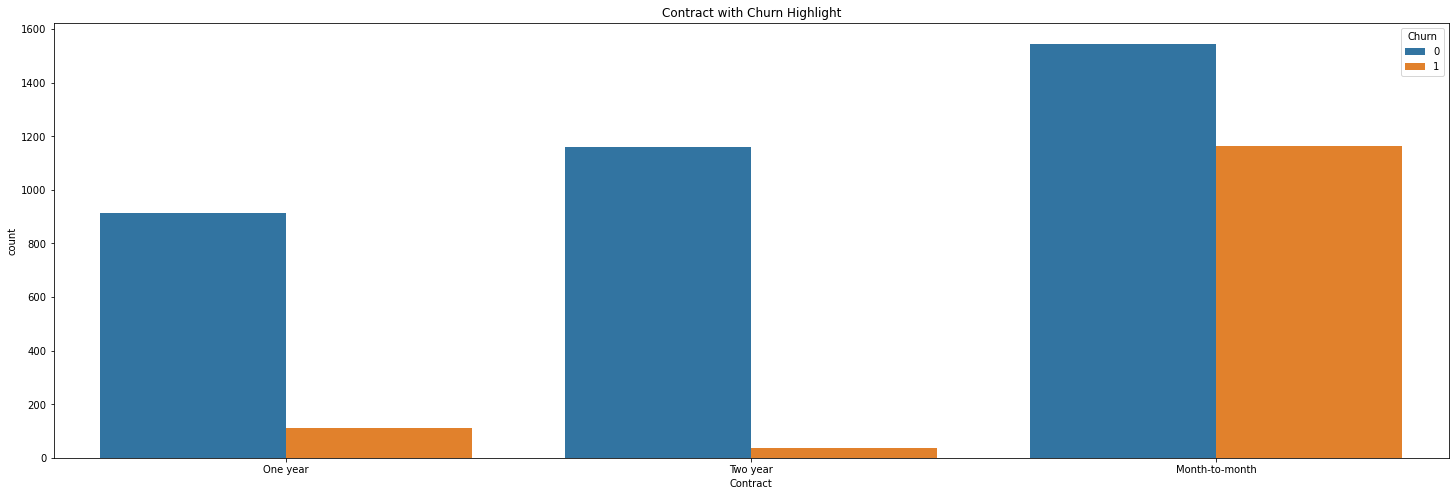

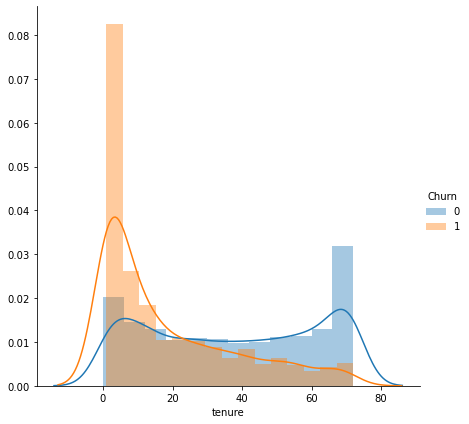

In [26]:
Bond(X)

Observations :
- People who have spent lesser time with the firm is basically has high rate of churning.
- Same thing we can observe in contract also as , people who has opt for monthly billing option are more likely to churn then yearly bonds.So people has to wait till they utilize their full yearly payments and as they stayed connected they are less likely to churn this we can see from tenure plot as well.

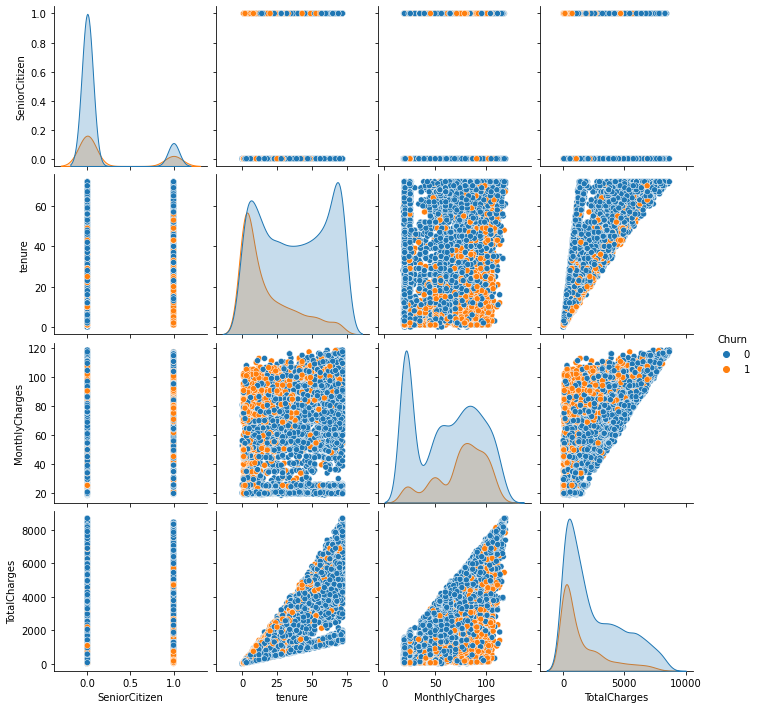

In [27]:
#Some Basic Pairplot.
sns.pairplot(X, hue="Churn")
plt.show()

Analysis:
1. Tenure : People with high Tenure period are less likely to Churn.
2. Monthly Charges : More the Charges more the churning rate. As expected.
3. Total Charges : Now this is intresting.
    - observation : As Total charges increases people are less likely to churn. 
    - Reason :As Total Charges are also based on contract and monthly Charges ,so More total Charges are basically could be because of year-year contract and we already observed people who stays with services for longer time are less likely to churn, vice-versa less total charges are due to people opting for month to month billing hence more churning rate.
4. Senior Citizen : Senior people has more churnning rate, but cant say for sure as no. of records for senior people is very less as compared to younger.

In [28]:
#Making a Function to analyse PhoneService.
def PhoneServicePlots(my_df, col):
    f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,8))
    
    #Phone services.
    sns.countplot(x=col ,data=my_df, hue='Churn', palette='rainbow', ax=ax1)
    ax1.set_title(f'{col} with Churn Count plot')
    
    #Multiple Lines
    sns.countplot(x='MultipleLines', data=my_df, hue="Churn", palette='rainbow', ax=ax2)
    ax2.set_title(f'People using MultipleLines with Churn highlighted Count plot')
    
    #Phone Service with Multiple Lines.
    sns.countplot(x=col , data=my_df, hue='MultipleLines', palette='rainbow', ax=ax3)
    ax3.set_title(f'{col} with Multiple Lines highlighted Plot.')
    plt.show()
    
    #Showing statistical count percentage records.
    result = pd.DataFrame()
    result[col] = list(my_df[col].unique())

    #value.append((len(my_df.loc[my_df[col]=="Yes",col])/len(my_df))*100)
    #value.append((len(my_df.loc[my_df[col]=="No",col])/len(my_df))*100)
    #result["% of Records"] = value
    #display(result)
    
    value = []
    churn = []
    count = []
    for i in list(my_df[col].unique()):
        value.append((len(my_df.loc[my_df[col]==i,col])/len(my_df))*100)
        churn.append((len(my_df.loc[(my_df["Churn"]==1) & (my_df[col]==i), col])/len(my_df.loc[my_df[col]==i,col]))*100)
        count.append(len(my_df.loc[my_df[col]==i,col]))
                     
    result["Count"] = count               
    result["% of Records"] = value
    result["Rate of Churn"] = churn
    display(result)
    

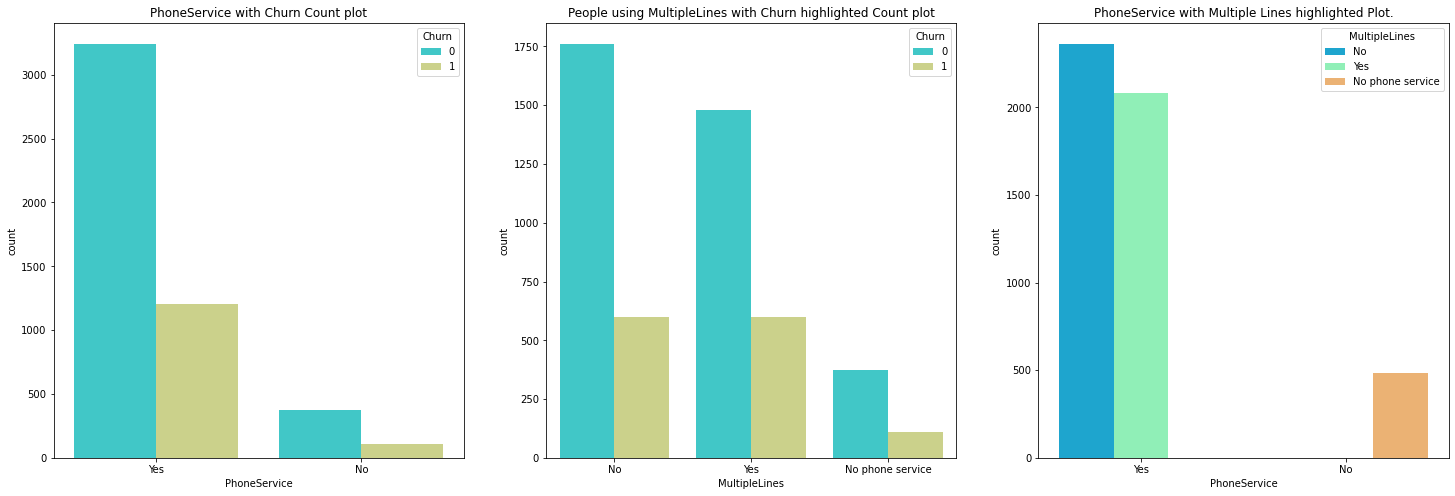

,PhoneService,Count,% of Records,Rate of Churn
0,Yes,4444,90.141988,27.025203
1,No,486,9.858012,22.839506


In [29]:
PhoneServicePlots(X, "PhoneService")

Analysis:
1. People with Phone Service has higher Rate of Churning than people who Dont.
   - Also, We can't Tell it for sure as there is very less no. of records almost 10% for people with No phone Services.
2. People with Multiple Lines has More rate of Churning then people who dont.
   - Reasons :
        - Might be due to high charges and less benifits.
        - Overall unhappy with the service.

In [30]:
#Making a function to analyse Internet Services.
def internet_service(my_df, col, s_cols):
    
    for sub_col in s_cols:
        f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(25,8))
    
        #Internet services.
        sns.countplot(x=col ,data=my_df, hue='Churn', palette='rainbow', ax=ax1)
        ax1.set_title(f'{col} with Churn Count plot')
    
        #sub_col with churn Highlight
        sns.countplot(x= sub_col, data=my_df, hue="Churn", palette='rainbow', ax=ax2)
        ax2.set_title(f'{sub_col} with Churn as highlighted Count plot')
    
        #Internet Service with sub_col Highlight.
        sns.countplot(x=col , data=my_df, hue=sub_col, palette='rainbow', ax=ax3)
        ax3.set_title(f'{col} with {sub_col} as highlighted Plot.')
        plt.show()
        
    
    #Showing statistical count percentage records.
    result = pd.DataFrame()
    result[col] = list(my_df[col].unique())

    #value.append((len(my_df.loc[my_df[col]=="Yes",col])/len(my_df))*100)
    #value.append((len(my_df.loc[my_df[col]=="No",col])/len(my_df))*100)
    #result["% of Records"] = value
    #display(result)
    
    value = []
    churn = []
    count = []
    for i in list(my_df[col].unique()):
        value.append((len(my_df.loc[my_df[col]==i,col])/len(my_df))*100)
        churn.append((len(my_df.loc[(my_df["Churn"]==1) & (my_df[col]==i), col])/len(my_df.loc[my_df[col]==i,col]))*100)
        count.append(len(my_df.loc[my_df[col]==i,col]))
    
    result["Count"] = count               
    result["% of Records"] = value
    result["Rate of Churn"] = churn
    display(result)
    
    #Sub_cols
    sub_result = pd.DataFrame()
    sub_Y = []
    sub_N = []
    for col in s_cols:
        sub_Y.append((len(my_df.loc[(my_df[col]=="Yes") & (my_df["Churn"]==1)])/len(my_df.loc[my_df[col]=="Yes"]))*100)
        sub_N.append((len(my_df.loc[(my_df[col]=="No") & (my_df["Churn"]==1)])/len(my_df.loc[my_df[col]=="No"]))*100)
    sub_result["Features"] = s_cols
    sub_result["Yes & Churning Rate"] = sub_Y
    sub_result["No & Churning Rate"] = sub_N
    display(sub_result)
    

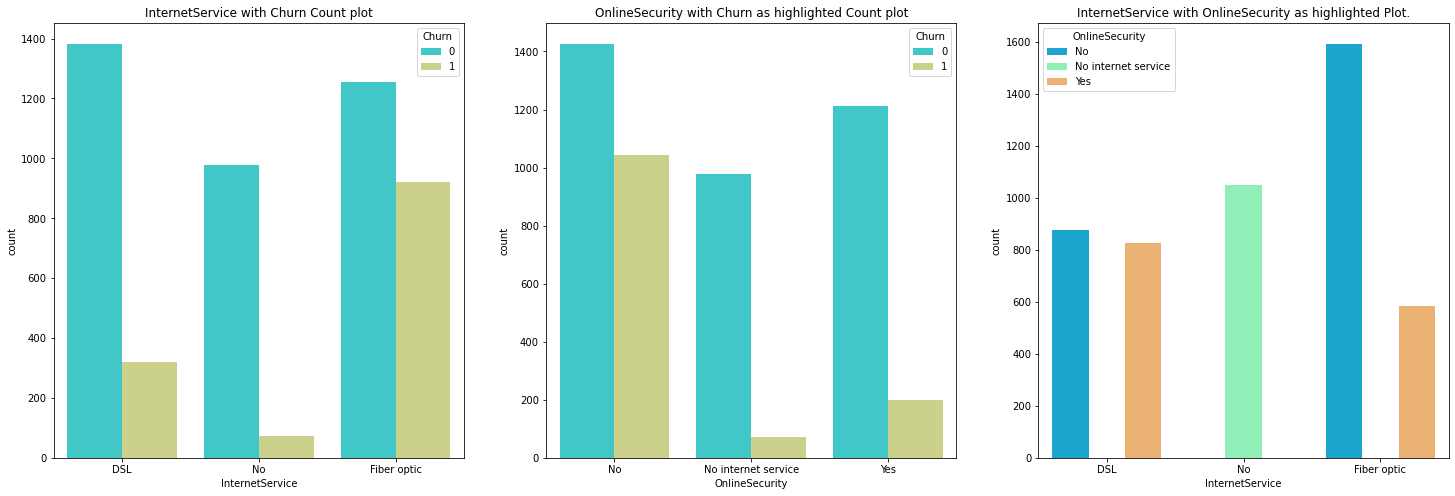

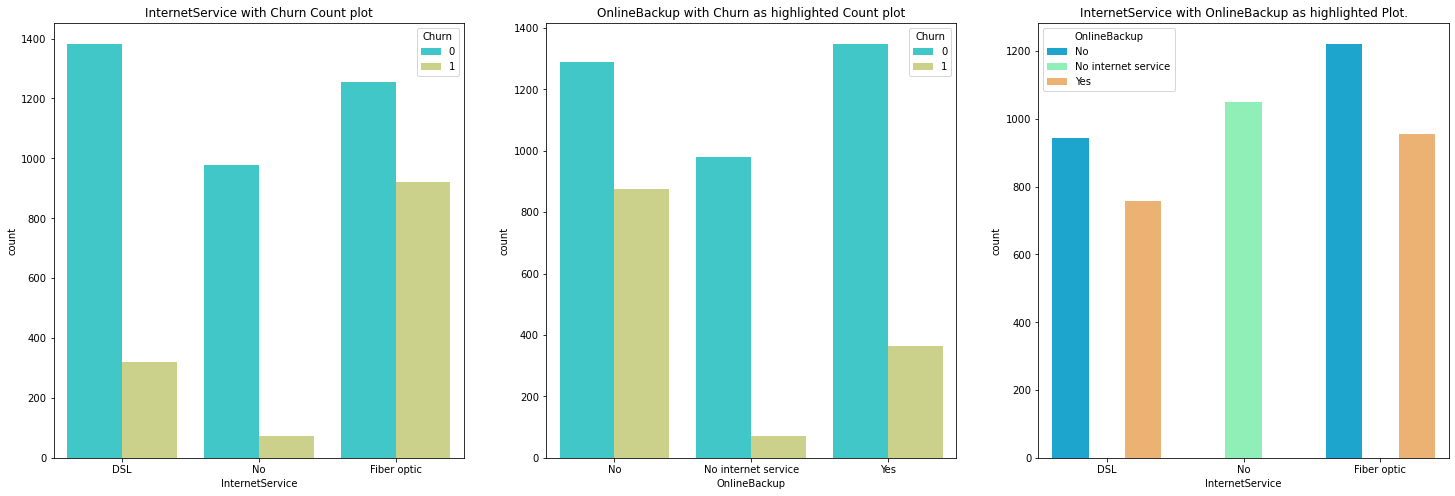

,InternetService,Count,% of Records,Rate of Churn
0,DSL,1703,34.543611,18.790370
1,No,1051,21.318458,6.850618
2,Fiber optic,2176,44.137931,42.279412


,Features,Yes & Churning Rate,No & Churning Rate
0,OnlineSecurity,14.042553,42.203321
1,OnlineBackup,21.203271,40.470697


In [31]:
sub = ["OnlineSecurity", "OnlineBackup"]
internet_service(X, col="InternetService", s_cols=sub)

Analysis:
1. Ineternet Service:
     - DSL: almost 20% churning rate.
     - Fiber optics :42% Churing rate. (A disaster)
     - No internet service : Has least churning rate 7%
2. Online Protection: (Important Feature)
     - Yes : Almost 14% of churning rate, People with Online protection is less likely to churn
     - No : almost 43% churning rate, people with no online protection are more likely to churn
3. Online Backup :
     - Yes : Almost 22% churning rate, people with Online Backup is less likely to Churn
     - No : Almost 40% churning rate, people without Online Backup are more likely to churn 
4. Fiber Optics : some of the reasons for whooping 42% churning rate are
     - Lesser people with Online Protection: almost 75% records in fiber optics dont have online protection and as we seen that online protection is very important factor for low churning.
     - More than 50% records are without Online Backup: also an impacting factor to lower the churning rate.
     - Overall performance might not be good.
5. Suggestions to Improve internet service:
     - Try selling DSL & Fiber optics with complementary Online Protection and Backup, or atleast any one of them.
     - People without Internet service are least likely to churn so try to improve the service as its not looking satisfactory enough for customers.

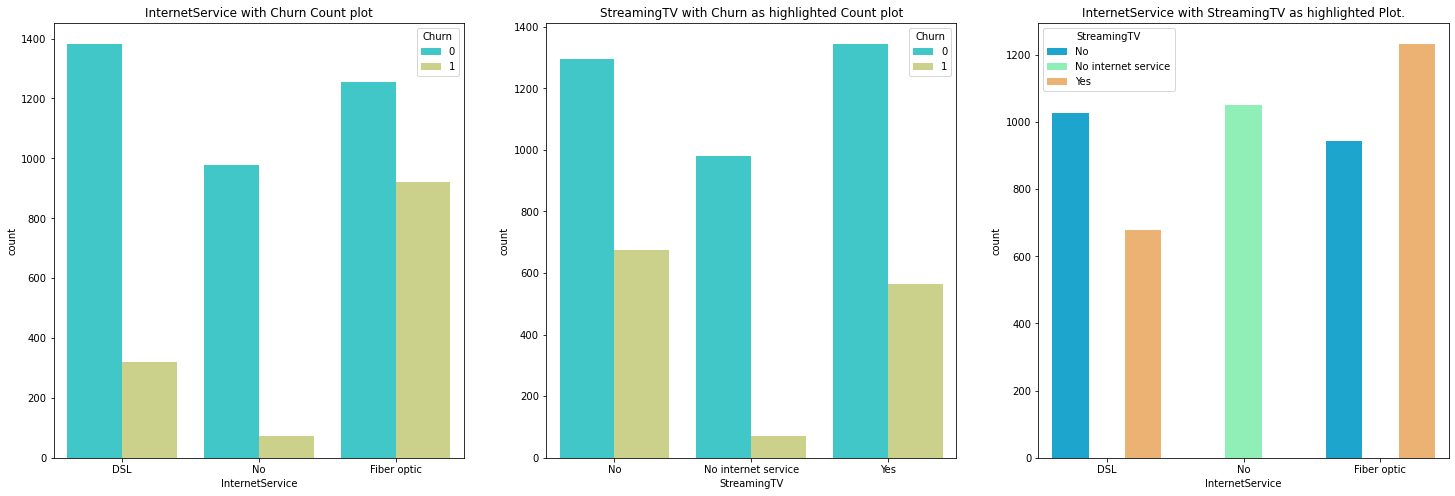

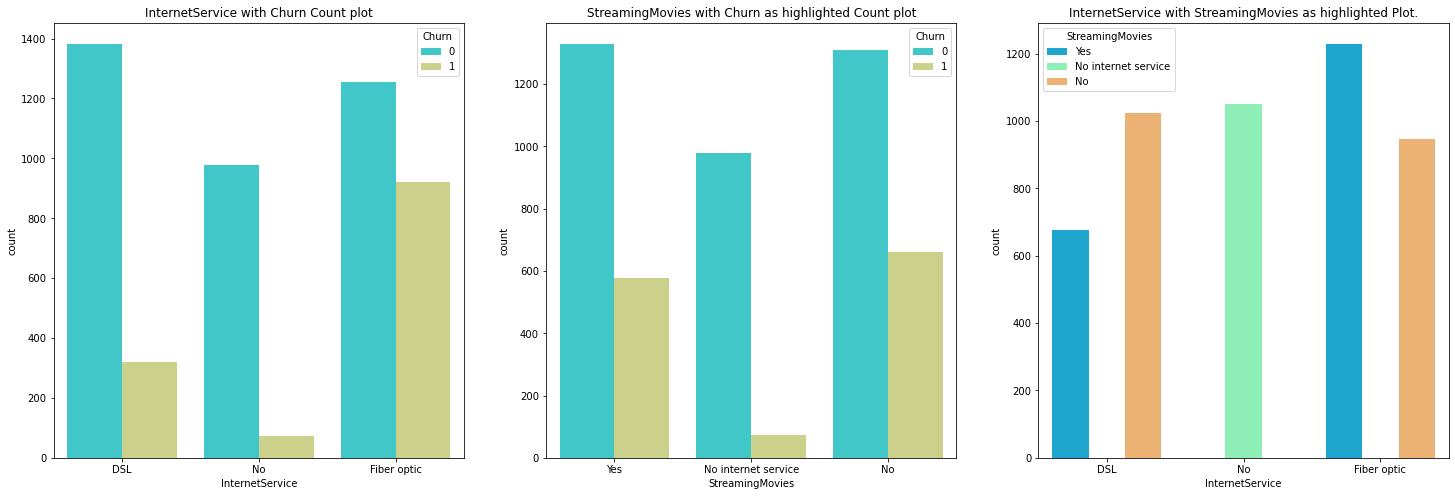

,InternetService,Count,% of Records,Rate of Churn
0,DSL,1703,34.543611,18.790370
1,No,1051,21.318458,6.850618
2,Fiber optic,2176,44.137931,42.279412


,Features,Yes & Churning Rate,No & Churning Rate
0,StreamingTV,29.581152,34.281361
1,StreamingMovies,30.293501,33.587012


In [32]:
#Internet Speed. (StreamingTV, StreamingMovies)
s_cols = ["StreamingTV", "StreamingMovies"]
internet_service(X, "InternetService", s_cols)

Analysis:
1. Internet Speed results are somewhat similar and that is People who prefers streaming-out of them 30% are churning but still 70% are satisfied.
-  lets have a deeper look

In [33]:
#Making a function to check how many people who prefer either of-streaming and also churning , belongs to no onlinesecurity group.
def NoSecurity_Streaming(my_df, cols):
    result = pd.DataFrame()
    result["Features"] = cols
    rate = []
    count = []
    for i in cols:
        count.append(len(my_df.loc[(my_df["Churn"]==1) & (my_df[i]=="Yes")]))
        rate.append(len(my_df.loc[(my_df["Churn"]==1) & (my_df["OnlineSecurity"]=="No") & (my_df[i]=="Yes")])/len(my_df.loc[(my_df["Churn"]==1) & (my_df[i]=="Yes")])*100)
    result["Yes and Churning"] = count
    result["%Yes and Churning with no Online Security "] = rate
    display(result)

In [34]:
NoSecurity_Streaming(X, s_cols)

,Features,Yes and Churning,%Yes and Churning with no Online Security
0,StreamingTV,565,81.59292
1,StreamingMovies,578,81.66090


- Important Observation :
    1. Out of that streaming 30% people who seem to be churning due to speed issue is actually churning because most of its records almost 82% are falling under people with No online Security and as we Analysed online peotection is the very important feature corresponds to Churning rate.
    2. So it can be concluded that there is very mini issue of internet speed.
    

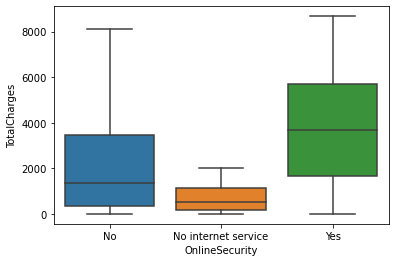

In [35]:
#checking how online security and total charges are related.
sns.boxplot(x="OnlineSecurity", y="TotalCharges",data=X)
plt.show()

In [36]:
#Checking for rest of the features.
def rest_features(telecom_cust, services):
    
    fig, axes = plt.subplots(2,3,figsize = (25,8))
    for i, item in enumerate(services):
        if i < 2:
            ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
        elif i >=2 and i < 4:
            ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-2,1],rot = 0)
            
        elif i < 6:
            ax = telecom_cust[item].value_counts().plot(kind = 'bar',ax=axes[i-4,2],rot = 0)
        ax.set_title(item)
    plt.show()

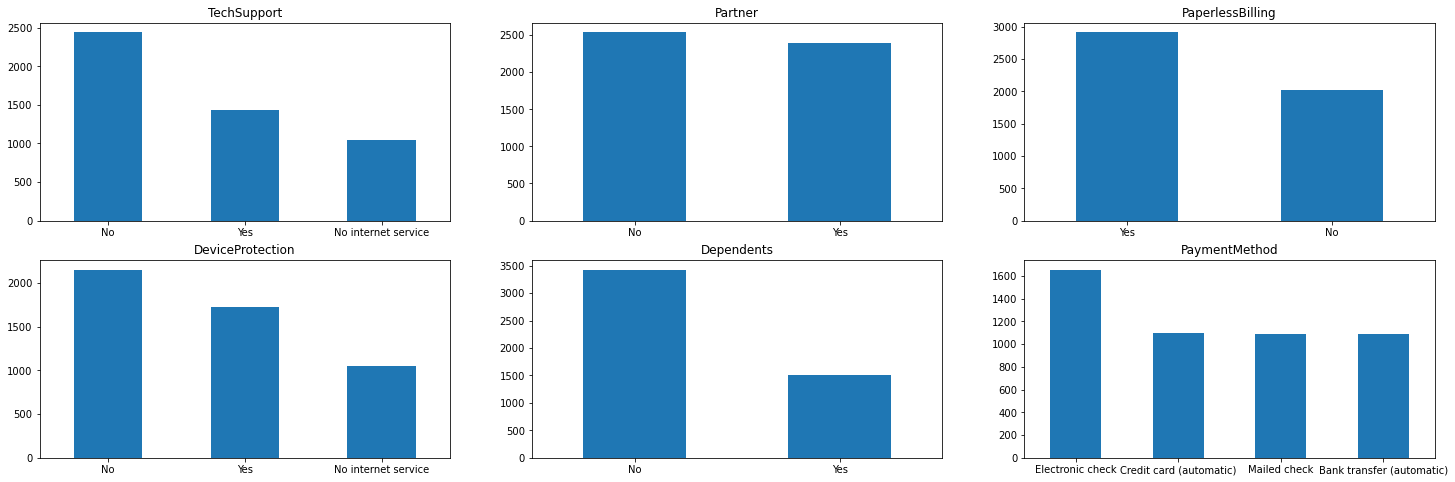

In [37]:
s_cols = ["TechSupport","DeviceProtection", "Partner", "Dependents",'PaperlessBilling', 'PaymentMethod' ]
rest_features(X, s_cols)

## EDA

In [38]:
X_num.head()

,tenure,MonthlyCharges,TotalCharges,Churn
1768,63,58.55,3503.500000,0
3556,6,19.45,113.500000,0
6018,33,20.35,689.750000,0
2840,23,84.40,1936.849976,0
6705,22,51.10,1232.900024,0


## Uni-variate Analysis.

In [39]:
#Making a custom Summary Function
def custom_summary(my_df):
    result = my_df.describe().T
    
    #Skewness value and Comment
    skew = []
    for col in my_df.columns:
        skew.append(my_df[col].skew())
    result["Skewness value"] = skew
    
    skew_comment = []
    for col in my_df.columns:
        if -1 > my_df[col].skew():
            skew_comment.append("Highly Negatively skewed")
        elif -1 <= my_df[col].skew() < -0.5:
            skew_comment.append("Moderately Negatively Skewed")
        elif -0.5 <= my_df[col].skew() < 0:
            skew_comment.append("fairly Negatively skewed")
        elif 0 < my_df[col].skew() <= 0.5:
            skew_comment.append("fairly Positively skewed")
        elif 0.5 < my_df[col].skew() <= 1:
            skew_comment.append("Moderately Positively skewed")
        else : skew_comment.append("Highly Positively skewed")
            
    result["Skewness comment"] = skew_comment
    
    #Kurtosis value and comment.
    kurtosis = []
    for col in my_df.columns:
        kurtosis.append(my_df[col].kurt())
    result["Kurtosis"] = kurtosis
    
    kurtosis_label=[]
    for i in result['Kurtosis']:
        if i >= 1:
            kurtosis_label.append('Leptokurtic Curve')
        elif i <= -1:
            kurtosis_label.append('Platykurtic Curve')
        else:
            kurtosis_label.append('Mesokurtic Curve')
    result['Kurtosis Comment'] = kurtosis_label
    
    #Outlier comment
    Outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            Q1 = my_df[col].quantile(0.25)
            Q2 = my_df[col].quantile(0.5)
            Q3 = my_df[col].quantile(0.75)
            IQR = Q3 - Q1
            LW = Q1 - 1.5*IQR
            UW = Q3 + 1.5*IQR
            if len(my_df[(my_df[col] < LW) | (my_df[col] > UW)]) > 0:
                Outliers_label.append('Have Outliers')
            else:
                Outliers_label.append('No Outliers')
    result['Outlier Comment'] = Outliers_label
    
    return result

In [40]:
custom_summary(X_num.drop("Churn", axis=1))

,count,mean,std,min,25%,50%,75%,max,Skewness value,Skewness comment,Kurtosis,Kurtosis Comment,Outlier Comment
tenure,4930.0,32.448682,24.594358,0.00,9.000000,29.000000,56.000000,72.000000,0.235593,fairly Positively skewed,-1.392526,Platykurtic Curve,No Outliers
MonthlyCharges,4930.0,64.931694,30.008789,18.25,36.175000,70.400000,89.850000,118.750000,-0.224108,fairly Negatively skewed,-1.244909,Platykurtic Curve,No Outliers
TotalCharges,4930.0,2287.952881,2268.181641,0.00,396.474991,1394.075012,3778.687561,8672.450195,0.955664,Moderately Positively skewed,-0.241031,Mesokurtic Curve,No Outliers


Analysis:
1. Tenure and MonthlyCharges has Platykurtic curve indicating that Avg-ly data points are far from mean hence higher standard deviation . In such cases Mean is not the best representative value for the Feature.
2. TotalCharges has MesoKurtic curve indicating data points are at Avg-ly fair distance from mean hence fair std. It is also moderately positively skewed means median is best representative value and if there is any outlier it has to be in Upper region.
3. As per IQR outlier detection method there is no Outliers.

In [41]:
#Cross-Checking for outliers via Percentile Method
def PD_treat(my_df, n):
    cols = my_df.columns
    
    result = pd.DataFrame()
    for i in cols:
        first = []
        last = []
        x = 0
        y = 1
        for j in range(1,n+1):
            #first
            first.append(my_df[i].quantile(x))
            #second
            last.append(my_df[i].quantile(y))
            x = x+0.01
            y = y-0.01
            
        result[i+"_first"] = first
        result[i+"_last"] = last
    
    return result
        
    

In [42]:
PD_treat(X_num.drop("Churn",axis=1),10)

,tenure_first,tenure_last,MonthlyCharges_first,MonthlyCharges_last,TotalCharges_first,TotalCharges_last
0,0.0,72.0,18.25,118.7500,0.000000,8672.450195
1,1.0,72.0,19.20,114.8855,19.750000,8035.123667
2,1.0,72.0,19.35,111.6920,20.450001,7724.928984
3,1.0,72.0,19.45,110.1500,32.959501,7387.362817
4,1.0,72.0,19.55,108.9500,45.099998,7148.254082
5,1.0,72.0,19.65,107.4500,49.900002,6918.662695
6,1.0,71.0,19.75,106.0500,55.524000,6727.488975
7,1.0,71.0,19.85,105.3500,69.550003,6548.343911
8,1.0,70.0,19.95,104.7500,71.182001,6367.880195
9,2.0,70.0,20.00,104.1000,76.572000,6145.056919


- No Extreme change in values found within 10percentile of both region.Hence No Outliers.

## Multi-Colinearity Analysis.

In [43]:
def calculate_vif(dataset):
    vif = pd.DataFrame()
    vif['features'] = dataset.columns
    vif['VIF_Values'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif['VIF_Values'] = round(vif['VIF_Values'] , 2)
    vif = vif.sort_values(by = 'VIF_Values' , ascending = False)
    return (vif)

In [44]:
calculate_vif(X_num.drop("Churn",axis=1))

,features,VIF_Values
2,TotalCharges,8.09
0,tenure,6.34
1,MonthlyCharges,3.36


- No Multi-colinearity issue ,as vif not greater than 10 which is standard Requirement for multi-colinearity treatment

In [45]:
#EDA for Cat features.
X_cat.head()

,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen
1768,Female,No,No,Yes,No,DSL,No,No,Yes,No,No,Yes,One year,No,Credit card (automatic),0,0
3556,Male,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0,0
6018,Male,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0,0
2840,Female,Yes,Yes,Yes,No,Fiber optic,Yes,Yes,No,Yes,No,No,Month-to-month,No,Mailed check,0,0
6705,Male,Yes,Yes,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,0,0


### Non-Linear Relationship Check for cat features.

In [46]:
def Label_encoder(my_df):
    le = LabelEncoder()
    result = le.fit_transform(my_df)
    return result

In [47]:
def Ordinal_encoder(my_df):
    oe = OrdinalEncoder()
    result = oe.fit_transform(my_df)
    return result

In [48]:
#Making a function to check non-linear relation between Churn and rest of the cat features.
def Select_feature(x, y):
    X_train = Ordinal_encoder(x)
    y_train = Label_encoder(y)
    fs = SelectKBest(score_func=mutual_info_classif,  k="all")
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    
    #calculating scores
    result = pd.DataFrame()
    scores = []
    for i in range(len(fs.scores_)):
        scores.append(fs.scores_[i])
    result["Features"] = x.columns
    result["Scores"] = scores 
    display(result)
    
    #plots
    plt.figure(figsize=(25,8))
    plt.bar([col for col in x.columns], fs.scores_)
    plt.show()

,Features,Scores
0,gender,0.000000
1,Partner,0.013373
2,Dependents,0.021943
3,PhoneService,0.011428
4,MultipleLines,0.005145
5,InternetService,0.065872
6,OnlineSecurity,0.080583
7,OnlineBackup,0.042112
8,DeviceProtection,0.044519
9,TechSupport,0.069552


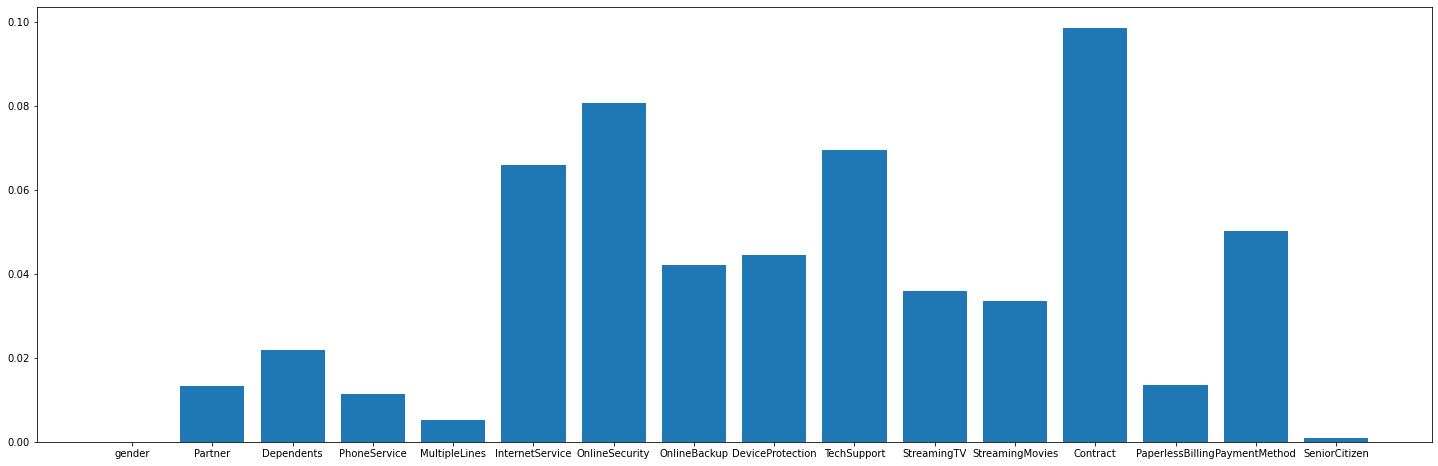

In [49]:
Select_feature(X_cat.drop(["Churn"],axis=1), y_train)

Analysis:
- from above observation it seems cat features doesn't have much non linear relation with Target variable, as they barely scores 0.1 as there max value.
- Among these "Contract" has the highest scores , because it is identical to tenure feature.
- Still lets keep them all ,as they might not be individually much related to target variable but collectively could lead to better results.

### Dummy variables for Cat columns

In [50]:
def dummies(my_df):
    my_df_en = pd.get_dummies(my_df, drop_first=True)
    return my_df_en

In [51]:
X_cat_en = dummies(X_cat.drop("Churn",axis=1))

In [52]:
X_cat_en.head()

,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1768,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
3556,0,1,1,1,1,0,0,0,1,1,...,1,0,1,0,1,0,0,0,0,1
6018,0,1,0,0,1,0,0,0,1,1,...,1,0,1,0,0,1,0,0,0,1
2840,0,0,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6705,0,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [53]:
#Making a complete dataset.
X_final = X_num.join(X_cat_en)
X_final.head()

,tenure,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1768,63,58.55,3503.500000,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
3556,6,19.45,113.500000,0,0,1,1,1,1,0,...,1,0,1,0,1,0,0,0,0,1
6018,33,20.35,689.750000,0,0,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0,1
2840,23,84.40,1936.849976,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1
6705,22,51.10,1232.900024,0,0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,1,0


## Model Building.

In [54]:
# X_final, y_train : training set
# X_test, y_test : testing set

In [55]:
def model_builder(model_name, model, X_train, y_train):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    y_train = y_train.astype("int")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    accuracy = round(accuracy_score(y_train, y_pred),5)
    recall = round(recall_score(y_train, y_pred),5)
    precision = round(precision_score(y_train, y_pred),5)
    f1_sc = round(f1_score(y_train, y_pred),5)
    result = [model_name, accuracy, precision, recall, f1_sc]
    return result

In [56]:
model_builder("LogisticRegression", LogisticRegression() ,X_train=X_final.drop("Churn",axis=1), y_train = X_final["Churn"])

['LogisticRegression', 0.8069, 0.66423, 0.55488, 0.60465]

In [57]:
def multiple_models(data, y):
    col_names = ['Model Name' , "Accuracy" ,"Precision","Recall","F1_Score"]
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = model_builder('LogisticRegression' , LogisticRegression() , data , y)
    result.loc[len(result)] = model_builder('KNN' , KNeighborsClassifier() , data , y)
    result.loc[len(result)] = model_builder('SVC' , SVC() , data , y)
    result.loc[len(result)] = model_builder('Random Forest' , RandomForestClassifier() , data , y)
    result.loc[len(result)] = model_builder('Gboost' , GradientBoostingClassifier() , data , y)
    result.loc[len(result)] = model_builder('XGboost' , XGBClassifier() , data , y)
    result.loc[len(result)] = model_builder('Adaboost' , AdaBoostClassifier() , data , y)

    return result.sort_values("Accuracy" , ascending = False)


In [58]:
multiple_models(X_final.drop("Churn",axis=1), X_final["Churn"])

,Model Name,Accuracy,Precision,Recall,F1_Score
3,Random Forest,0.99817,0.99619,0.99695,0.99657
5,XGboost,0.95051,0.92516,0.88567,0.90498
1,KNN,0.83935,0.71277,0.66387,0.68745
4,Gboost,0.82961,0.71933,0.58994,0.64824
2,SVC,0.81684,0.70889,0.52896,0.60585
6,Adaboost,0.80913,0.66637,0.56631,0.61228
0,LogisticRegression,0.80690,0.66423,0.55488,0.60465


In [59]:
def k_fold_cv(X, y , fold = 10):
    y = y.astype("int")
    score_LR = cross_val_score(LogisticRegression() , X, y , cv= fold)
    #score_DTR = cross_val_score(DecisionTreeClassifier() , X, y , cv= fold)
    score_SVC = cross_val_score(SVC() , X, y , cv= fold)
    score_RandomForest = cross_val_score(RandomForestClassifier() , X, y , cv= fold)
    score_KNN = cross_val_score(KNeighborsClassifier() , X, y , cv= fold)
    score_Gboost = cross_val_score(GradientBoostingClassifier() , X, y , cv= fold)
    score_XGBoost = cross_val_score(XGBClassifier() , X, y , cv= fold)
    score_AdaBoost = cross_val_score(AdaBoostClassifier() , X, y , cv= fold)
    
    
    model_name = ['Logistic Regression' , 'SVC' , 'Random Forest' , 'KNN' , 'Gboost' , 'XGBoost' , 'AdaBoost']
    scores = [score_LR, score_SVC ,score_RandomForest, score_KNN, score_Gboost, score_XGBoost, score_AdaBoost]  
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy' , ascending = False)
                                                                                                                          
    

In [60]:
k_fold_cv(X_final.drop("Churn",axis=1), y_train)

,Model Name,CV Accuracy,CV STD
0,Logistic Regression,0.806085,0.011938
6,AdaBoost,0.802637,0.011689
4,Gboost,0.801826,0.010063
2,Random Forest,0.787018,0.015607
5,XGBoost,0.778905,0.013332
3,KNN,0.755984,0.011583
1,SVC,0.733874,0.000811


## Hyperparameter Tuning.

In [61]:
# Lets take the top-3 models ie, Logistic regression, Gradient Boost and Adaboost
#Additionally taking Random forest and XGBoost as well , because they were having highest Recall score which is more important in this prediction of Churning project.

In [62]:
def tuning(X, y, fold=10):
    
    #parameters grid for tuning
    param_LR = {'solver' : ["newton-cg", "lbfgs", "liblinear","sag", "saga"]}
    param_ADA = {'n_estimators': list(range(2, 102, 2)), 'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
    param_GB = {'ccp_alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], "max_features" : ["auto", "sqrt", "log2"]}
    param_RF = {"max_features":["sqrt", "log2", 'None'], 'ccp_alpha' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], "criterion":["gini", "entropy", "log_loss"]}
    param_XGB = {'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], "booster":["gbtree", "gblinear","dart"], "max_depth": list(range(1,8,1))}
    
    #Hyperparameter Tuning
    tune_RF = GridSearchCV(RandomForestClassifier(), param_RF, cv=fold)
    tune_XGB = GridSearchCV(XGBClassifier(), param_XGB, cv=fold)
    tune_LR = GridSearchCV(LogisticRegression(), param_LR, cv = fold)
    tune_ADA = GridSearchCV(AdaBoostClassifier(), param_ADA, cv = fold)
    tune_GB = GridSearchCV(GradientBoostingClassifier(), param_GB, cv=fold)
    
    #Fitting X and Y
    y = y.astype("int")
    tune_RF.fit(X,y)
    tune_XGB.fit(X,y)
    tune_LR.fit(X,y)
    tune_ADA.fit(X,y)
    tune_GB.fit(X,y)
    
    tune = [tune_RF, tune_XGB, tune_LR, tune_ADA, tune_GB]
    models = ["RandomForest", "XGB","LogisticRegression", "ADBoost", "GBoost"]
    
    for i in range(len(tune)):
        print('models: ', models[i])
        print('best Parameters: ', tune[i].best_params_)
        
    

In [63]:
#tuning(X_final.drop("Churn",axis=1), y_train)

## Post-Hyparameter Tuning.

In [64]:
def  cv_post_hpt(X,y, fold = 10):
    y = y.astype('int')
    score_RF = cross_val_score(RandomForestClassifier(ccp_alpha=0.1, criterion="gini", max_features="sqrt"), X,y, cv=fold)
    score_XGB = cross_val_score(XGBClassifier(booster='gbtree', learning_rate=0.3, max_depth =1), X,y, cv=fold)
    score_LR = cross_val_score(LogisticRegression(solver="lbfgs"), X,y,cv=fold)
    score_ADA = cross_val_score(AdaBoostClassifier(learning_rate=0.5, n_estimators=84), X,y,cv=fold)
    score_GB = cross_val_score(GradientBoostingClassifier(ccp_alpha=0.1, max_features='auto'), X,y,cv=fold)
    model_name = ["RandomForest", "XGB",'Logistic Regression', 'AdaBoost', 'GBoost']
    scores = [score_RF, score_XGB, score_LR, score_ADA, score_GB]  
    result = []
    
    for i in range(len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name , score_mean , score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ['Model Name' , 'CV Accuracy' , 'CV STD'])
    return k_fold_df.sort_values('CV Accuracy' , ascending = False)
                       

In [65]:
cv_post_hpt(X_final.drop("Churn", axis=1), y_train)

,Model Name,CV Accuracy,CV STD
3,AdaBoost,0.809331,0.015179
1,XGB,0.807708,0.012950
2,Logistic Regression,0.806085,0.011938
0,RandomForest,0.733874,0.000811
4,GBoost,0.733874,0.000811


## Testing.

In [66]:
#Preparing X_test dataset.
X_test_en = dummies(X_test.select_dtypes(include='object'))
X_test_f = X_test.select_dtypes(exclude='object').join(X_test_en)
values = X_test_f.pop("SeniorCitizen")
X_test_f.insert(loc=3, column="SeniorCitizen", value=values, allow_duplicates=False)
X_test_f.head()

,tenure,MonthlyCharges,TotalCharges,SeniorCitizen,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6418,31,79.30,2484.000000,0,1,1,0,1,0,1,...,0,1,0,1,1,0,1,0,0,1
1948,2,80.75,159.449997,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4497,60,97.95,5867.000000,1,1,1,0,1,0,0,...,0,1,0,1,1,0,1,0,1,0
66,47,78.90,3650.350098,0,1,1,0,1,0,1,...,0,0,0,0,1,0,1,0,1,0
1705,55,90.45,5044.799805,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0


In [67]:
def Testing(model_name, model, X_train, y_train, X_test, y_test):
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    y_train = y_train.astype("int")
    y_test = y_test.astype("int")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred),5)
    recall = round(recall_score(y_test, y_pred),5)
    precision = round(precision_score(y_test, y_pred),5)
    f1_sc = round(f1_score(y_test, y_pred),5)
    result = [model_name, accuracy, precision, recall, f1_sc]
    return result

In [68]:
def multiple_models_testing(data, y, X_test, y_test):
    col_names = ['Model Name' , "Accuracy" ,"Precision","Recall","F1_Score"]
    result = pd.DataFrame(columns = col_names)
    result.loc[len(result)] = Testing("XGB", XGBClassifier(booster='gbtree', learning_rate=0.3, max_depth =1), data , y, X_test, y_test)
    result.loc[len(result)] = Testing("RandomForest", RandomForestClassifier(ccp_alpha=0.1, criterion="gini", max_features="sqrt"), data , y, X_test, y_test)
    result.loc[len(result)] = Testing('LogisticRegression' , LogisticRegression(solver="lbfgs") , data , y, X_test, y_test)
    result.loc[len(result)] = Testing('Gboost' , GradientBoostingClassifier(ccp_alpha=0.1, max_features='auto') , data , y, X_test, y_test)
    result.loc[len(result)] = Testing('Adaboost' , AdaBoostClassifier(learning_rate=0.5, n_estimators=84) , data , y, X_test, y_test)
    return result.sort_values("Accuracy" , ascending = False)


In [69]:
multiple_models_testing(X_final.drop("Churn",axis=1), y_train, X_test_f, y_test)

,Model Name,Accuracy,Precision,Recall,F1_Score
0,XGB,0.80786,0.66966,0.53501,0.59481
2,LogisticRegression,0.80454,0.64876,0.56373,0.60327
4,Adaboost,0.80407,0.66067,0.52783,0.58683
1,RandomForest,0.73639,0.00000,0.00000,0.00000
3,Gboost,0.73639,0.00000,0.00000,0.00000


## Conclusion:
- Logistic Regression : training accuracy = 80.6% , Testing accuracy = 80.45% , recall = 56.37%
    - Best model
- XGB : training accuracy = 80.77% , testing accuracy = 80.78% , Recall = 53%
    - 2nd best
- AdaBoost : training accuracy = 80%, testing accuracy = 80%, Recall = 52.7%
    - 3rd best